# Libraries

In [ ]:
from tvb.simulator.plot.phase_plane_interactive import PhasePlaneInteractive
from tvb.simulator.lab import os, connectivity, plot_connectivity
from time import time
import tvb.simulator.simulator as simulator
import tvb.simulator.models as models
import tvb.simulator.noise as noise
import tvb.simulator.coupling as coupling
import tvb.simulator.integrators as integrators
import tvb.simulator.monitors as monitors
import tvb.datatypes.connectivity as connectivity
import Tools.display as Td
import Tools.matrices as Tm
import Tools.functions as Tf
%pylab inline

In [2]:
models = reload(models)
coupling = reload(coupling)
simulator = reload(simulator)

----------
# Configuration

**Parameters**

In [174]:
P = 0.95         # Excitation / Inhibition ratio
G = 60.          # Gain
taux = 20.       # Time constant for potentials
sigx = 0.5e-4 #2**-13    # Noise on potentials
vel = 1500.      # Velocity (default= 3m/s)
dt = 2**-1       # Time step

**Model**

In [17]:
model = models.ContinuousHopfield(**{'taux':taux})

$$\tau_{x} \dot{x_{i}} = -x_{i} + sum(W_{i,j} A_{j})$$
$$A_{i} = 1/2 (1 + tanh(G (P x_{i} - \theta)))$$

**Connectivity**

In [18]:
Connectome = connectivity.Connectivity()
Connectome.speed = array([vel])
Connectome.weights = Connectome.normalised_weights('region')
Connectome.configure()
print 'The Connectome contains %i Nodes' %Connectome.areas.shape[0]

The Connectome contains 998 Nodes


**Coupling**

In [204]:
# Global threshold
theta = (Connectome.weights.sum(0) * 0.5).mean()
cCoupling = coupling.StaticSigmoidal(**{'G':G,
                                        'P':P,
                                        'theta':theta})

**Integrator & Noise**

In [176]:
hiss = noise.Additive(nsig = array([sigx,]))
integrator = integrators.EulerStochastic(**{'dt':dt,
                                            'noise':hiss})

**Monitors**

In [21]:
mon_raw = monitors.Raw()
mon_tav = monitors.TemporalAverage(period=2**-1)
what_to_watch = (mon_raw, mon_tav)

**Others**

In [22]:
patterns    = []

In [205]:
initialDens = 0.25

----------
# Initialization & Run

**Initial Conditions**

In [206]:
x_0 = rand(1,1,Connectome.areas.shape[0],1)
x_0[x_0 <  (1.- initialDens)] = 0
x_0[x_0 >= (1.- initialDens)] = 1
#x_0 = patterns[-1].reshape(x_0.shape)

**Simulator**

In [207]:
sim = simulator.Simulator(model = model, 
                          connectivity = Connectome,
                          coupling = cCoupling,
                          initial_conditions = x_0,
                          integrator = integrator, 
                          monitors = what_to_watch)
sim.configure()

**Start**

In [208]:
raw_data = []
raw_time = []

**Continue**

In [209]:
t0 = time()
for raw, tav in sim(simulation_length=2**9):
    if raw is not None:
        raw_time.append(raw[0])
        raw_data.append(raw[1][0,0,:,0])

print time()-t0, 's'

103.349363089 s


----------
# Results & Display

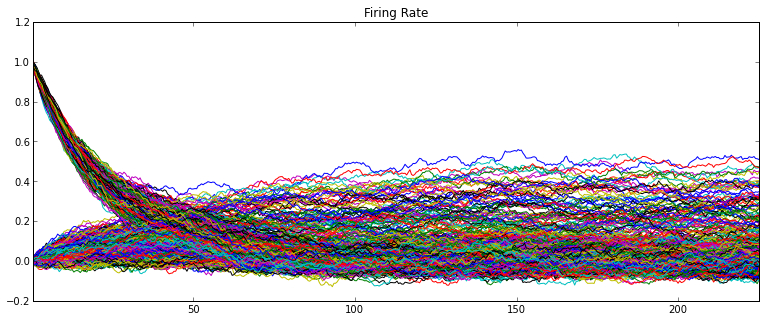

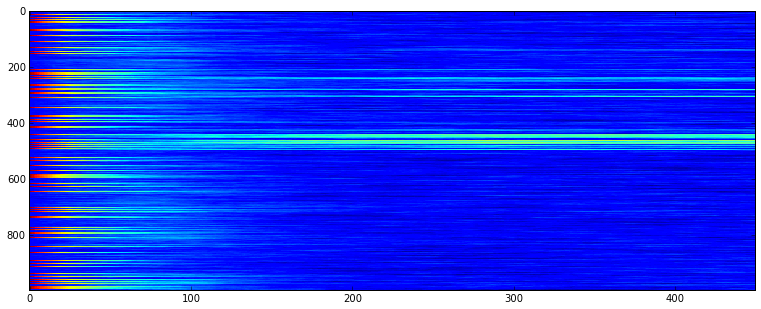

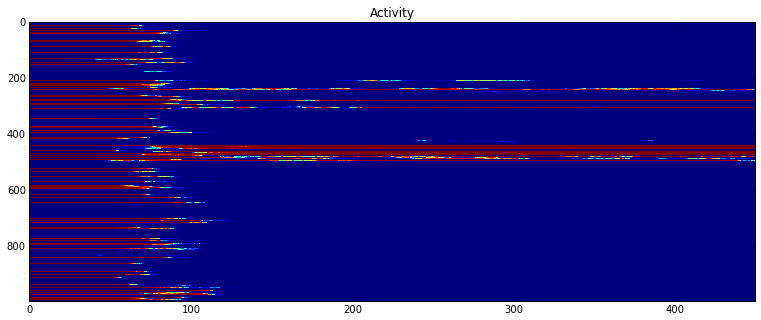

In [210]:
RAW = numpy.array(raw_data)

#Plot raw time series
figure(figsize=(13,5))
xlim(min(raw_time), max(raw_time[:450]))
plot(raw_time[:450], RAW[:450])
title("Firing Rate")
figure(2, figsize=(13,5))
imshow(RAW[:450].T, interpolation="nearest", aspect='auto')

#Plot temporally averaged time series
figure(figsize=(13,5))
imshow(Tf.sigmoid(RAW[:450],
                  P = cCoupling.P,
                  G = cCoupling.G,
                  T = cCoupling.theta).T,
       interpolation="nearest", aspect='auto')
title("Activity")

show()

**Attractors**

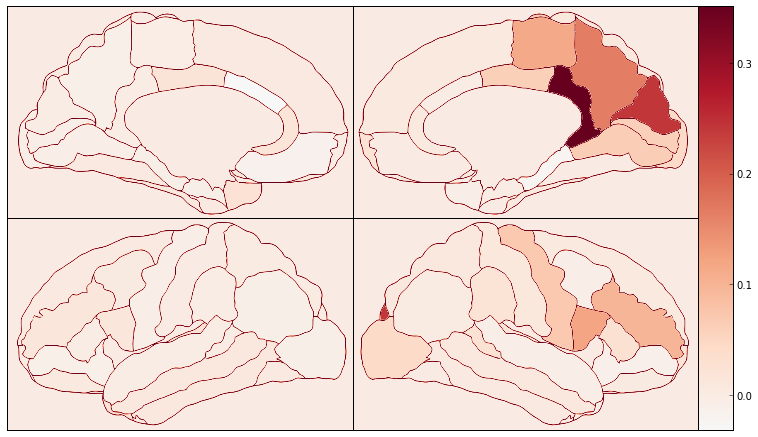

In [211]:
candidat = RAW[-1].copy()
Td.hagmannParcellation(candidat, fig=figure(figsize(13,8)))

In [212]:
patterns = Tm.patternChecking(candidat, patterns, test='corrcoef')
print 'Number of Attractors:', len(patterns)

Number of Attractors: 6


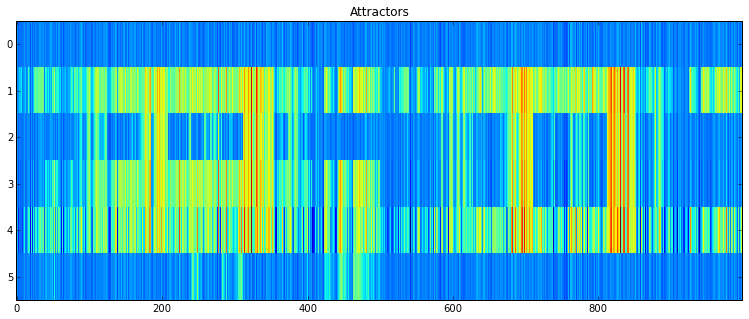

In [213]:
figure('Attractors', figsize=(13,5))
imshow(array(patterns), interpolation='nearest', aspect='auto')
title("Attractors")
show()